<a href="https://colab.research.google.com/github/MAL3X-01/DS-Unit-1-Sprint-1-Dealing-With-Data/blob/master/module3-databackedassertions/LS_DS_114_Making_Data_backed_Assertions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lambda School Data Science - Making Data-backed Assertions

This is, for many, the main point of data science - to create and support reasoned arguments based on evidence. It's not a topic to master in a day, but it is worth some focused time thinking about and structuring your approach to it.

# New Section

# New Section

## Lecture - generating a confounding variable

The prewatch material told a story about a hypothetical health condition where both the drug usage and overall health outcome were related to gender - thus making gender a confounding variable, obfuscating the possible relationship between the drug and the outcome.

Let's use Python to generate data that actually behaves in this fashion!

In [1]:
import random
dir(random)  # Reminding ourselves what we can do here

['BPF',
 'LOG4',
 'NV_MAGICCONST',
 'RECIP_BPF',
 'Random',
 'SG_MAGICCONST',
 'SystemRandom',
 'TWOPI',
 '_BuiltinMethodType',
 '_MethodType',
 '_Sequence',
 '_Set',
 '__all__',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 '_acos',
 '_bisect',
 '_ceil',
 '_cos',
 '_e',
 '_exp',
 '_inst',
 '_itertools',
 '_log',
 '_pi',
 '_random',
 '_sha512',
 '_sin',
 '_sqrt',
 '_test',
 '_test_generator',
 '_urandom',
 '_warn',
 'betavariate',
 'choice',
 'choices',
 'expovariate',
 'gammavariate',
 'gauss',
 'getrandbits',
 'getstate',
 'lognormvariate',
 'normalvariate',
 'paretovariate',
 'randint',
 'random',
 'randrange',
 'sample',
 'seed',
 'setstate',
 'shuffle',
 'triangular',
 'uniform',
 'vonmisesvariate',
 'weibullvariate']

In [2]:
# Let's think of another scenario:
# We work for a company that sells accessories for mobile phones.
# They have an ecommerce site, and we are supposed to analyze logs
# to determine what sort of usage is related to purchases, and thus guide
# website development to encourage higher conversion.

# The hypothesis - users who spend longer on the site tend
# to spend more. Seems reasonable, no?

# But there's a confounding variable! If they're on a phone, they:
# a) Spend less time on the site, but
# b) Are more likely to be interested in the actual products!

# Let's use namedtuple to represent our data

from collections import namedtuple
# purchased and mobile are bools, time_on_site in seconds
User = namedtuple('User', ['purchased','time_on_site', 'mobile'])

example_user = User(False, 12, False)
print(example_user)

User(purchased=False, time_on_site=12, mobile=False)


In [3]:
# And now let's generate 1000 example users
# 750 mobile, 250 not (i.e. desktop)
# A desktop user has a base conversion likelihood of 10%
# And it goes up by 1% for each 15 seconds they spend on the site
# And they spend anywhere from 10 seconds to 10 minutes on the site (uniform)
# Mobile users spend on average half as much time on the site as desktop
# But have three times as much base likelihood of buying something

users = []

for _ in range(250):
  # Desktop users
  time_on_site = random.uniform(10, 600)
  purchased = random.random() < 0.1 + (time_on_site / 1500)
  users.append(User(purchased, time_on_site, False))
  
for _ in range(750):
  # Mobile users
  time_on_site = random.uniform(5, 300)
  purchased = random.random() < 0.3 + (time_on_site / 1500)
  users.append(User(purchased, time_on_site, True))
  
random.shuffle(users)
print(users[:10])

[User(purchased=False, time_on_site=122.74326527986973, mobile=False), User(purchased=True, time_on_site=214.3443622794344, mobile=True), User(purchased=False, time_on_site=72.75544599900707, mobile=True), User(purchased=False, time_on_site=156.11268181126985, mobile=True), User(purchased=False, time_on_site=70.50513490916373, mobile=True), User(purchased=False, time_on_site=17.458325827141227, mobile=True), User(purchased=False, time_on_site=269.54123840442986, mobile=True), User(purchased=True, time_on_site=261.01669209245216, mobile=False), User(purchased=False, time_on_site=85.40093276252263, mobile=True), User(purchased=True, time_on_site=195.02807532826213, mobile=True)]


In [4]:
# Let's put this in a dataframe so we can look at it more easily
import pandas as pd
user_data = pd.DataFrame(users)
user_data.head()

,purchased,time_on_site,mobile
0,False,122.743265,False
1,True,214.344362,True
2,False,72.755446,True
3,False,156.112682,True
4,False,70.505135,True


In [5]:
# Let's use crosstabulation to try to see what's going on
pd.crosstab(user_data['purchased'], user_data['time_on_site'])

time_on_site,5.240108522671418,5.584502610497177,5.94543215129277,6.357598722073128,6.397804689727435,7.017058617272721,7.064337849661122,7.225459170644026,7.482092184963228,7.6083272900616565,7.620725466975804,7.862471480485116,8.094890074509479,8.538347969254051,9.808561769298052,9.887289885889476,9.891397727608492,9.956689305945233,10.38397198736348,11.096661005414727,11.210487115123069,11.363331696890024,11.526744340804655,11.545118065036089,11.552920127574897,11.870674531615133,11.975812297076793,12.465186936336245,12.751905072329823,14.024840511420123,14.357395858825367,14.376676650180544,14.683288034129834,14.856138524811957,14.952729764122498,15.64761771569284,16.63139465093277,16.899846511155012,17.10455972290376,17.12783759868155,...,493.20369801081426,498.25935732776634,507.8336680995052,508.8161359934215,517.9952707072994,518.0048176079396,521.7950149973426,521.9323229624713,522.5929634307087,526.6154016434115,529.9834720445133,531.4778441078081,531.8065445091787,532.029576657429,539.9374208016327,542.8967396213657,543.6443683553168,545.7892919797115,546.8052927570004,546.9135898660141,548.1918385186531,550.4473155932857,553.2156475298984,553.7189305180459,566.4432347963927,566.4781775896112,567.8218407407411,568.1374873468338,569.170857139754,575.0951899714944,578.4419786202748,581.5259899378101,584.3940285151082,584.9411810353835,585.5638963916198,587.958139697733,589.4187415389327,592.864575423515,594.6776608113329,598.8171461908764
purchased,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
False,1,1,1,0,1,1,1,1,1,0,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1,0,1,0,0,1,1,1,1,1,1,1,1,1,0,1,...,1,1,0,1,1,0,1,1,1,1,1,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,1,1,0,0,1,1,1,0,0,1,1,0,0
True,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,1,0,...,0,0,1,0,0,1,0,0,0,0,0,1,1,1,1,1,1,0,1,0,1,1,1,1,0,1,1,0,0,1,1,0,0,0,1,1,0,0,1,1


In [6]:
# OK, that's not quite what we want
# Time is continuous! We need to put it in discrete buckets
# Pandas calls these bins, and pandas.cut helps make them

time_bins = pd.cut(user_data['time_on_site'], 5)  # 5 equal-sized bins
pd.crosstab(user_data['purchased'], time_bins)

time_on_site,"(4.647, 123.956]","(123.956, 242.671]","(242.671, 361.386]","(361.386, 480.102]","(480.102, 598.817]"
purchased,,,,,
False,266,211,95,37,20
True,100,143,87,15,26


In [7]:
# We can make this a bit clearer by normalizing (getting %)
pd.crosstab(user_data['purchased'], time_bins, normalize='columns')

time_on_site,"(4.647, 123.956]","(123.956, 242.671]","(242.671, 361.386]","(361.386, 480.102]","(480.102, 598.817]"
purchased,,,,,
False,0.726776,0.596045,0.521978,0.711538,0.434783
True,0.273224,0.403955,0.478022,0.288462,0.565217


In [8]:
# That seems counter to our hypothesis
# More time on the site can actually have fewer purchases

# But we know why, since we generated the data!
# Let's look at mobile and purchased
pd.crosstab(user_data['purchased'], user_data['mobile'], normalize='columns')

mobile,False,True
purchased,,
False,0.7,0.605333
True,0.3,0.394667


In [0]:
# Yep, mobile users are more likely to buy things
# But we're still not seeing the *whole* story until we look at all 3 at once

# Live/stretch goal - how can we do that?

## Assignment - what's going on here?

Consider the data in `persons.csv` (already prepared for you, in the repo for the week). It has four columns - a unique id, followed by age (in years), weight (in lbs), and exercise time (in minutes/week) of 1200 (hypothetical) people.

Try to figure out which variables are possibly related to each other, and which may be confounding relationships.

In [10]:
# importing python libraries to read and manupilate data
import pandas as pd 
import numpy as np

persons_data = pd.read_csv('https://raw.githubusercontent.com/MAL3X-01/DS-Unit-1-Sprint-1-Dealing-With-Data/master/module3-databackedassertions/persons.csv')
persons_data.head()

,Unnamed: 0,age,weight,exercise_time
0,0,44,118,192
1,1,41,161,35
2,2,46,128,220
3,3,39,216,57
4,4,28,116,182


In [11]:
persons_data.info()      # info of the data type and the amount of data for each feature

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1200 entries, 0 to 1199
Data columns (total 4 columns):
Unnamed: 0       1200 non-null int64
age              1200 non-null int64
weight           1200 non-null int64
exercise_time    1200 non-null int64
dtypes: int64(4)
memory usage: 37.6 KB


In [12]:
persons_data.describe()    # More description and useful data for each feature

,Unnamed: 0,age,weight,exercise_time
count,1200.000000,1200.000000,1200.000000,1200.000000
mean,599.500000,48.396667,153.540833,134.910833
std,346.554469,18.166802,35.132182,85.548895
min,0.000000,18.000000,100.000000,0.000000
25%,299.750000,33.000000,125.000000,65.000000
50%,599.500000,48.000000,149.000000,122.000000
75%,899.250000,64.000000,180.250000,206.000000
max,1199.000000,80.000000,246.000000,300.000000


In [13]:
persons_data.isnull().sum()     # Check for null values

Unnamed: 0       0
age              0
weight           0
exercise_time    0
dtype: int64

In [14]:
# Renaming first column to 'id'
persons_data.rename(index=str, columns={"Unnamed: 0": "id"}, inplace=True)
persons_data.head()

,id,age,weight,exercise_time
0,0,44,118,192
1,1,41,161,35
2,2,46,128,220
3,3,39,216,57
4,4,28,116,182


In [15]:
# Adding 2 columns with boolean values, determining if the age and weight are over the mean
persons_data['overAgeMean'] = persons_data['age'].apply(lambda x: 'True' if x >= 48.396667 else 'False')
persons_data['overWeightMean'] = persons_data['weight'].apply(lambda x: 'True' if x>=153.540833 else 'False')

persons_data.head(10)

,id,age,weight,exercise_time,overAgeMean,overWeightMean
0,0,44,118,192,False,False
1,1,41,161,35,False,True
2,2,46,128,220,False,False
3,3,39,216,57,False,True
4,4,28,116,182,False,False
5,5,58,103,165,True,False
6,6,55,161,107,True,True
7,7,21,188,37,False,True
8,8,55,216,79,True,True
9,9,50,127,267,True,False


In [16]:
!pip install pandas==0.23.4    # newer version was buggy 

In [34]:
# made bins for time exercise and age
time_bins = pd.cut(persons_data['exercise_time'], 3)
age_bins = pd.cut(persons_data['age'], 3)

pd.crosstab(persons_data['weight'], age_bins)    # a crosstab showing the weight and age 

age,"(17.938, 38.667]","(38.667, 59.333]","(59.333, 80.0]"
weight,,,
100,4,5,6
101,6,2,2
102,6,5,2
103,2,4,2
104,2,4,3
105,5,3,2
106,6,0,2
107,3,7,1
108,8,6,5


In [33]:
pd.crosstab(persons_data['weight'], time_bins)   # crosstab showing weight and time

exercise_time,"(-0.3, 100.0]","(100.0, 200.0]","(200.0, 300.0]"
weight,,,
100,6,2,7
101,1,5,4
102,3,3,7
103,3,2,3
104,4,1,4
105,3,3,4
106,1,5,2
107,1,6,4
108,3,6,10


In [19]:
# Cross Tab that is showing the exercise time correlation with the extra 2 columns I added
ct1 = pd.crosstab([persons_data['overWeightMean'], persons_data['overAgeMean']], 
                  time_bins, normalize='columns')
ct1

exercise_time               (-0.3, 100.0]       ...        (200.0, 300.0]
overWeightMean overAgeMean                      ...                      
False          False             0.150495       ...              0.546624
               True              0.209901       ...              0.282958
True           False             0.257426       ...              0.102894
               True              0.382178       ...              0.067524

[4 rows x 3 columns]

In [35]:
time_bins.value_counts()

(-0.3, 100.0]     505
(100.0, 200.0]    384
(200.0, 300.0]    311
Name: exercise_time, dtype: int64

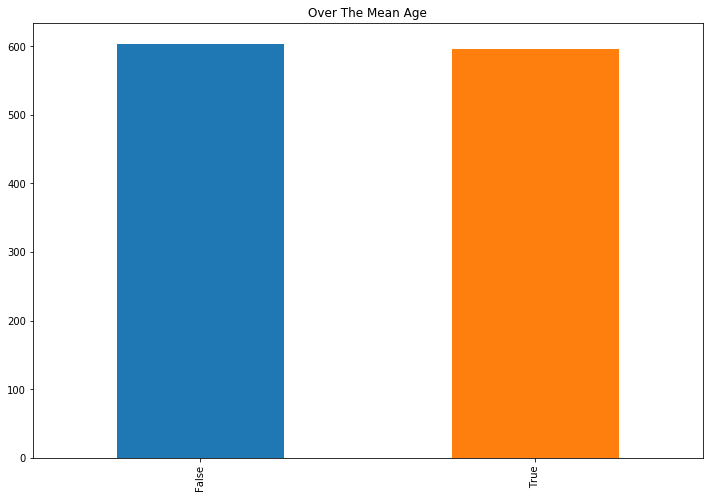

In [45]:
# Countplot showing true or false if someone is over the age mean
persons_data['overAgeMean'].value_counts().plot.bar(title='Over The Mean Age');  

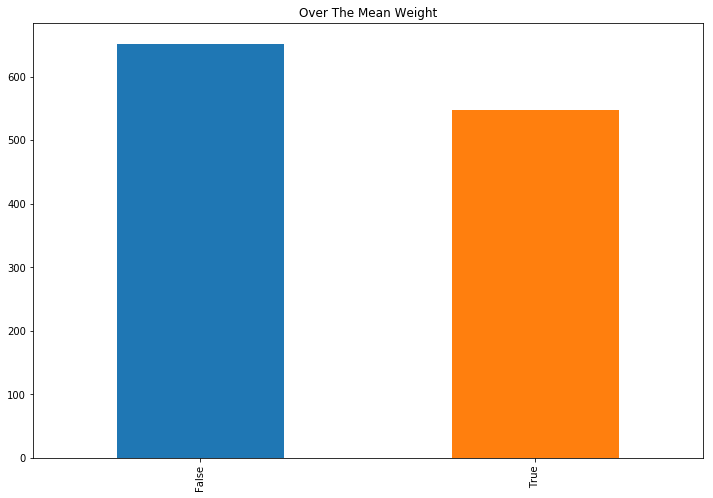

In [44]:
# Countplot showing true of false if someone is over the weight mean
persons_data['overWeightMean'].value_counts().plot.bar(title='Over The Mean Weight');

Populating the interactive namespace from numpy and matplotlib


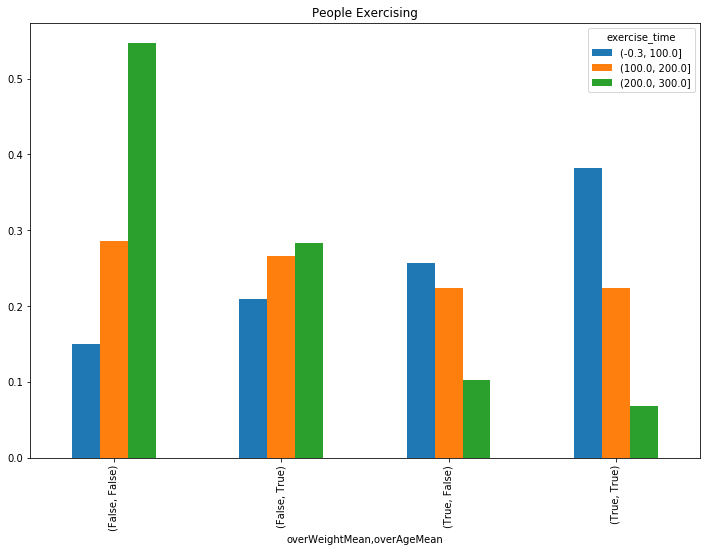

In [42]:
%pylab inline

# Plot bar showing the correlation with overweight/age mean with exercise time
ct1.plot.bar(figsize(12,8), title='People Exercising');

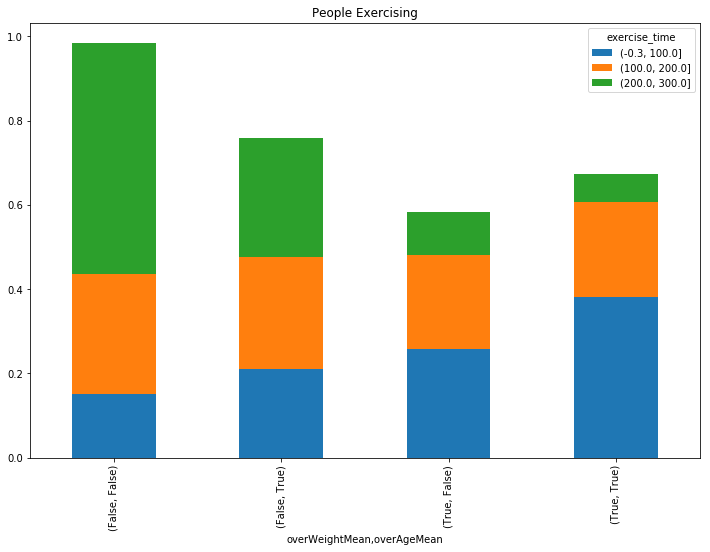

In [41]:
# same plot bar as above but stacked
ct1.plot(kind='bar', stacked=True, title='People Exercising');

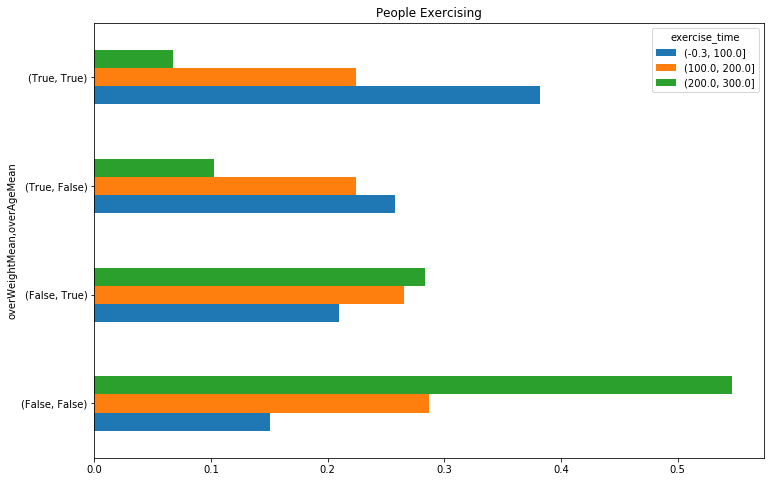

In [40]:
ct1.plot(kind='barh', title='People Exercising');

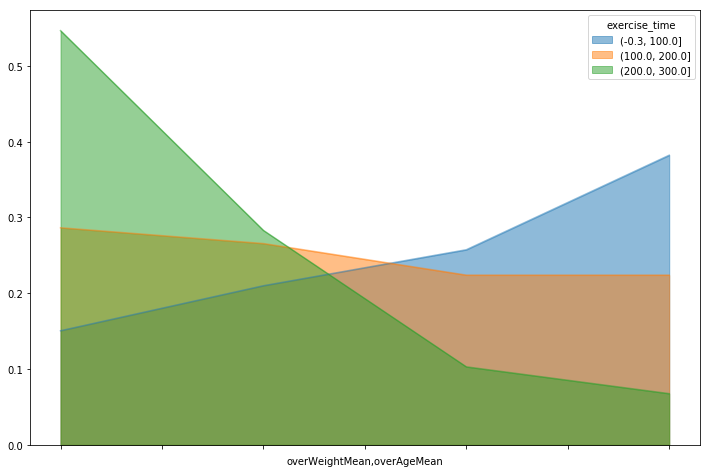

In [58]:
# More time spent exercise decreasing the higher the age and weight
ct1.plot.area(stacked=False)

In [72]:
ct2 = pd.crosstab([persons_data['overWeightMean']], age_bins, normalize='columns')
ct2

age,"(17.938, 38.667]","(38.667, 59.333]","(59.333, 80.0]"
overWeightMean,,,
False,0.584507,0.591146,0.451282
True,0.415493,0.408854,0.548718


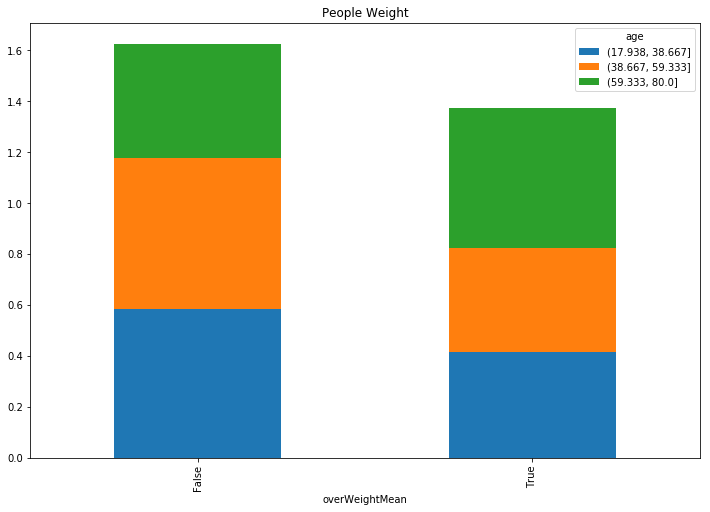

In [75]:
# older people tend to weigh more
ct2.plot(kind='bar', stacked=True, title='People Weight');

### Assignment questions

After you've worked on some code, answer the following questions in this text block:

1.  What are the variable types in the data?
2.  What are the relationships between the variables?
3.  Which relationships are "real", and which spurious?


Answers:

1. The variable type in this data are all 'int' not including the ones I added.

2. The more weight and higher age decrease amount of time spent exercising per week.

3.  The younger the person is the more time they spend exercising per week. Also the older they are they tend to exercise more but short amount of time per week. The spurious relationship will be the id number because its just a random number given to each person.

## Stretch goals and resources

Following are *optional* things for you to take a look at. Focus on the above assignment first, and make sure to commit and push your changes to GitHub.

- [Spurious Correlations](http://tylervigen.com/spurious-correlations)
- [NIH on controlling for confounding variables](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4017459/)

Stretch goals:

- Produce your own plot inspired by the Spurious Correlation visualizations (and consider writing a blog post about it - both the content and how you made it)
- Pick one of the techniques that NIH highlights for confounding variables - we'll be going into many of them later, but see if you can find which Python modules may help (hint - check scikit-learn)